In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

In [31]:
xrp_min = pd.read_csv("data/minute.csv")[['time', 'XRP_price']]
train_min = xrp_min[xrp_min.time <= "2022-02-06"]
valid_min = xrp_min[(xrp_min.time > "2022-02-06") & (xrp_min.time <= "2022-02-13")]
test_min = xrp_min[xrp_min.time > "2022-02-13"]
print(xrp_min.shape, train_min.shape, valid_min.shape, test_min.shape)
train_min.shape[0] +  valid_min.shape[0] + test_min.shape[0] == xrp_min.shape[0]

(76312, 2) (43199, 2) (10080, 2) (23033, 2)


True

In [32]:
xrp_min

,time,XRP_price
0,2022-01-07 00:01:00,0.72640
1,2022-01-07 00:02:00,0.72640
2,2022-01-07 00:03:00,0.72645
3,2022-01-07 00:04:00,0.72665
4,2022-01-07 00:05:00,0.72665
...,...,...
76307,2022-02-28 23:48:00,0.77130
76308,2022-02-28 23:49:00,0.77125
76309,2022-02-28 23:50:00,0.77100
76310,2022-02-28 23:51:00,0.77065


<AxesSubplot:>

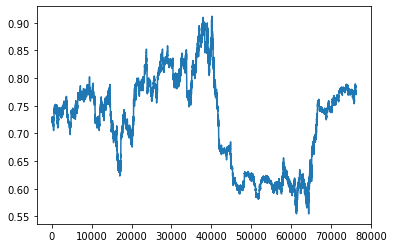

In [33]:
xrp['XRP_price'].plot()

## AR (min)

In [34]:
ar_model1 = AutoReg(train_min['XRP_price'], lags=1).fit()
print(ar_model1.summary())

                            AutoReg Model Results                             
Dep. Variable:              XRP_price   No. Observations:                43199
Model:                     AutoReg(1)   Log Likelihood              245286.497
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Tue, 15 Mar 2022   AIC                        -490566.994
Time:                        18:40:05   BIC                        -490540.973
Sample:                             1   HQIC                       -490558.787
                                43199                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.419e-05   5.64e-05      1.138      0.255   -4.64e-05       0.000
XRP_price.L1     0.9999    7.3e-05   1.37e+04      0.000       1.000       1.000
                                    Roots   

In [35]:
ar_model5 = AutoReg(train_min['XRP_price'], lags=5).fit()
print(ar_model5.summary())

                            AutoReg Model Results                             
Dep. Variable:              XRP_price   No. Observations:                43199
Model:                     AutoReg(5)   Log Likelihood              256239.197
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Tue, 15 Mar 2022   AIC                        -512464.394
Time:                        18:40:06   BIC                        -512403.680
Sample:                             5   HQIC                       -512445.245
                                43199                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.444e-05   4.38e-05      1.701      0.089   -1.13e-05       0.000
XRP_price.L1     1.8002      0.005    380.258      0.000       1.791       1.810
XRP_price.L2    -1.3961      0.010   -146.89

In [36]:
ar_model30 = AutoReg(xrp_min['XRP_price'], lags=30).fit()
print(ar_model30.summary())

                            AutoReg Model Results                             
Dep. Variable:              XRP_price   No. Observations:                76312
Model:                    AutoReg(30)   Log Likelihood              464716.130
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Tue, 15 Mar 2022   AIC                        -929368.259
Time:                        18:40:07   BIC                        -929072.509
Sample:                            30   HQIC                       -929277.400
                                76312                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.949e-05   1.75e-05      1.685      0.092   -4.81e-06    6.38e-05
XRP_price.L1      1.8699      0.004    516.472      0.000       1.863       1.877
XRP_price.L2     -1.6113      0.008   -2

In [60]:
test_min.shape

(23033, 2)

In [62]:
x.shape

(23033,)

In [63]:
forecast_min.shape

(53279,)

In [64]:
forecast_min

23033    0.796818
23034    0.797342
23035    0.796374
23036    0.797501
23037    0.796281
           ...   
76307    0.771353
76308    0.771242
76309    0.771240
76310    0.770780
76311    0.770531
Length: 53279, dtype: float64

ValueError: x and y must have same first dimension, but have shapes (23033,) and (53279,)

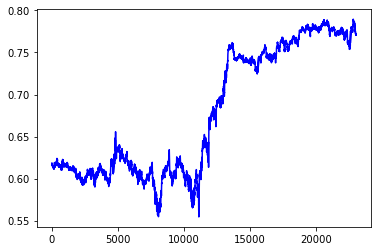

In [58]:
forecast_min = ar_model30.predict(test_min.shape[0])
x = np.arange(test_min.shape[0])
plt.plot(x, test_min['XRP_price'], c='blue')
plt.plot(x, forecast_min.values, c='green')
plt.show()

In [57]:
forecast_min

23033    0.796818
23034    0.797342
23035    0.796374
23036    0.797501
23037    0.796281
           ...   
76307    0.771353
76308    0.771242
76309    0.771240
76310    0.770780
76311    0.770531
Length: 53279, dtype: float64

In [48]:
x

array([    0,     1,     2, ..., 23030, 23031, 23032])

In [50]:
forecast_min

23033    0.796818
23034    0.797342
23035    0.796374
23036    0.797501
23037    0.796281
           ...   
76307    0.771353
76308    0.771242
76309    0.771240
76310    0.770780
76311    0.770531
Length: 53279, dtype: float64

## AR (val)

In [37]:
xrp_val = pd.read_csv("data/hour.csv")[['time', 'XRP_price']]
train_val = xrp_val[xrp_val.time <= "2022-02-06"]
valid_val = xrp_val[(xrp_val.time > "2022-02-06") & (xrp_val.time <= "2022-02-13")]
test_val = xrp_val[xrp_val.time > "2022-02-13"]
print(xrp_val.shape, train_val.shape, valid_val.shape, test_val.shape)
train_val.shape[0] +  valid_val.shape[0] + test_val.shape[0] == xrp_val.shape[0]

(1271, 2) (719, 2) (168, 2) (384, 2)


True

In [38]:
ar_model1 = AutoReg(train_val['XRP_price'], lags=1).fit()
print(ar_model1.summary())

                            AutoReg Model Results                             
Dep. Variable:              XRP_price   No. Observations:                  719
Model:                     AutoReg(1)   Log Likelihood                2652.155
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Tue, 15 Mar 2022   AIC                          -5298.309
Time:                        18:40:49   BIC                          -5284.580
Sample:                             1   HQIC                         -5293.008
                                  719                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0033      0.003      1.025      0.305      -0.003       0.010
XRP_price.L1     0.9957      0.004    241.829      0.000       0.988       1.004
                                    Roots   

In [40]:
ar_model12 = AutoReg(train_val['XRP_price'], lags=12).fit()
print(ar_model12.summary())

                            AutoReg Model Results                             
Dep. Variable:              XRP_price   No. Observations:                  719
Model:                    AutoReg(12)   Log Likelihood                2819.783
Method:               Conditional MLE   S.D. of innovations              0.004
Date:                Tue, 15 Mar 2022   AIC                          -5611.567
Time:                        18:41:36   BIC                          -5547.713
Sample:                            12   HQIC                         -5586.895
                                  719                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0049      0.003      1.940      0.052   -5.01e-05       0.010
XRP_price.L1      1.8719      0.038     49.784      0.000       1.798       1.946
XRP_price.L2     -1.6115      0.080    -

## AR (dien)

In [41]:
xrp_day = pd.read_csv("data/day.csv")[['time', 'XRP_price']]
train_day = xrp_day[xrp_day.time <= "2022-02-06"]
valid_day = xrp_day[(xrp_day.time > "2022-02-06") & (xrp_day.time <= "2022-02-13")]
test_day = xrp_day[xrp_day.time > "2022-02-13"]
print(xrp_day.shape, train_day.shape, valid_day.shape, test_day.shape)
train_day.shape[0] +  valid_day.shape[0] + test_day.shape[0] == xrp_day.shape[0]

(52, 2) (30, 2) (7, 2) (15, 2)


True

In [42]:
ar_model1 = AutoReg(train_day['XRP_price'], lags=1).fit()
print(ar_model1.summary())

                            AutoReg Model Results                             
Dep. Variable:              XRP_price   No. Observations:                   30
Model:                     AutoReg(1)   Log Likelihood                 193.585
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 15 Mar 2022   AIC                           -381.171
Time:                        18:45:01   BIC                           -377.069
Sample:                             1   HQIC                          -379.886
                                   30                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0818      0.053      1.536      0.125      -0.023       0.186
XRP_price.L1     0.8924      0.070     12.737      0.000       0.755       1.030
                                    Roots   

In [44]:
ar_model7 = AutoReg(train_day['XRP_price'], lags=7).fit()
print(ar_model7.summary())

                            AutoReg Model Results                             
Dep. Variable:              XRP_price   No. Observations:                   30
Model:                     AutoReg(7)   Log Likelihood                 160.712
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 15 Mar 2022   AIC                           -303.423
Time:                        18:45:37   BIC                           -293.204
Sample:                             7   HQIC                          -300.853
                                   30                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1412      0.071      1.978      0.048       0.001       0.281
XRP_price.L1     1.6768      0.216      7.771      0.000       1.254       2.100
XRP_price.L2    -1.4320      0.396     -3.61

XRP BTC
AR ARMA ARIMA GARCH
MIN HOUR DAY